# **Machine Learning project**

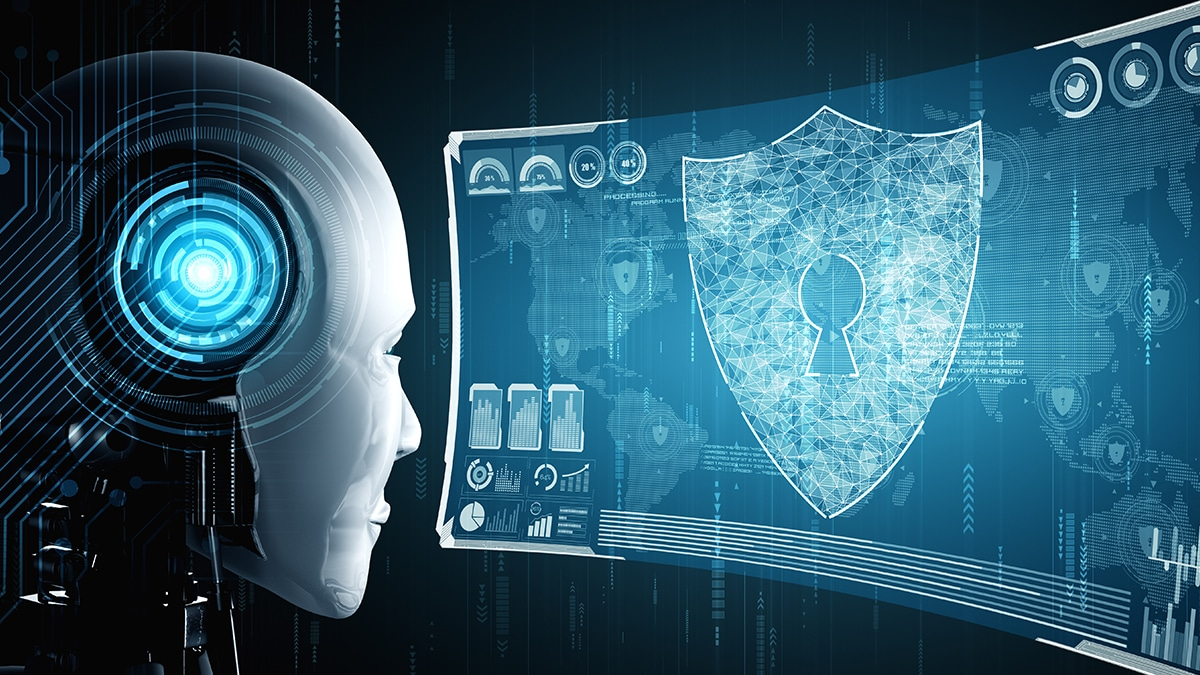

Sébastien BOIS, Maxime BOUET, Lesly LUU, Clarisse MICHAUD--WINKLER

In this notebook we will train several classifier models to estimate the best prediction on the type of network connections. We consider that a connection can be either **normal** or **malicious** during this exercise. We have a lot of different features for which we will try to interpretate their correlation to the type of connection.

## 1. Prerequisites

### 1.1 Importing libraries

First, we must import all the models, tools and libraries that we will use in this process.
We use Scikit-learn classification models and tools so we must import all of them. 
Also, we will have to perform some operations on the datasets so we must import both pandas and numpy libraries.
Lastly, we will use seaborn and MatplotLib to display some information on graphs to have better results' interpretation

In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

### 1.2 Loading data
We have two different datasets at disposal: a training one and a testing one. 
To perform well, we must load them separatly into two pandas' dataframe.

In [159]:
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

To understand the differences between the two datasets, we can display both headers. This will inform us on the type of data stored and on the dimensions of both datasets.

In [160]:
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [161]:
test_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,11


We can notice that we have an additional column in the training dataset. It corresponds to the label, in other words the expected type for the classification. If we look further, we observe that it is not only about being normal or malicious. It also descibes the type of malicious connection on the network (normal, neptune, ...).

## 2. Feature engineering

It is impossible to train a classification model on the current features. Indeed, a good-working model requires the data to be numerical and normalized. We can't make calculation on data which do not have the same shape. 

### 2.1. Missing data

First, let's check if there are missing information for some data. If we find some missing features, we must drop the related data so that it does not impact the model's training.

In [162]:
totalTrain = train_data.isnull().sum().sort_values(ascending=False)
totalTest = test_data.isnull().sum().sort_values(ascending=False)
columns = pd.DataFrame(data={'Missing for train_data': totalTrain,'Missing for test_data': totalTest})
columns.head(43)

,Missing for train_data,Missing for test_data
attack,0,NaN
count,0,0.0
diff_srv_rate,0,0.0
dst_bytes,0,0.0
dst_host_count,0,0.0
dst_host_diff_srv_rate,0,0.0
dst_host_rerror_rate,0,0.0
dst_host_same_src_port_rate,0,0.0
dst_host_same_srv_rate,0,0.0
dst_host_serror_rate,0,0.0


By looking at the resulting dataframe, we find out that there are no missing information in out training and testing data. We can however notice a NaN value for the **attack** feature in the test datasets. It is normal since it is the label column in the training set and it corresponds to the values we want to predict at the end.  

### 2.2 New feature
Currently, the label corresponds to the ***attack*** feature. However, we don't want to predict the exact state of the connection (normal, neptune, ...). We only want to detect if the connection is normal or malicious. We can generalize it by creating a new feature called ***network_status*** which is defined as follow:


*   network_status = 0 means that the connection is malicious
*   network_status = 1 means that the connection is normal



In [163]:
new_feature = 'network_status'
train_data[new_feature] = (train_data['attack'] == 'normal').astype(int)

### 2.3 Identification of useless features

We consider a feature as useless when its value does not impact the classifier model. We can make the assumption that a feature is useless if it always have the same value, no matter the data classification. To detect those features, we compute separatly each feature's sum and look into it. If this sum is equal to zero, we must look this feature in more details. 

In [164]:
df2 = train_data.select_dtypes(include=['int64','float64'])
head = []
somme = dict()
head = df2.columns
i = 0
for h in head:
  somme[h] = train_data[h].sum()
pd.DataFrame.from_dict(somme, orient="index").head(43)

,0
duration,3.617247e+07
src_bytes,5.740179e+09
dst_bytes,2.491634e+09
land,2.500000e+01
wrong_fragment,2.858000e+03
urgent,1.400000e+01
hot,2.575000e+04
num_failed_logins,1.540000e+02
logged_in,4.985200e+04
num_compromised,3.517800e+04


Then, we distinguish that ***num_outbound_cmds*** and ***is_host_login*** features respectly have 0 and 1 as results of the sums. The feature ***num_outbound_cmds*** is a numeric feature counting the outbound commands in a FTP session. For all the connections at disposal, we counted zero outbound command, we can then neglict this feature. Concerning the ***is_host_login*** feature, we only had one case over 100'000 where the connection was host logged. We can also neglict it since it is a unique case.

Now, we can drop the ***num_outbound_cmds*** and ***is_host_login*** features that we considered as useless above but also the ***attack*** feature. Indeed, we do not need it anymore since we created the ***network_status*** feature from it. If we keep it, it will only disturb our classifiers.

In [165]:
train_data.drop('num_outbound_cmds', axis=1, inplace=True) # Always 0
train_data.drop('is_host_login', axis=1, inplace=True) # Only one true value for the 100000 lines
train_data.drop('attack', axis=1, inplace=True) # We don't need it anymore since we have the feature network_status

### 2.4 Categorical features





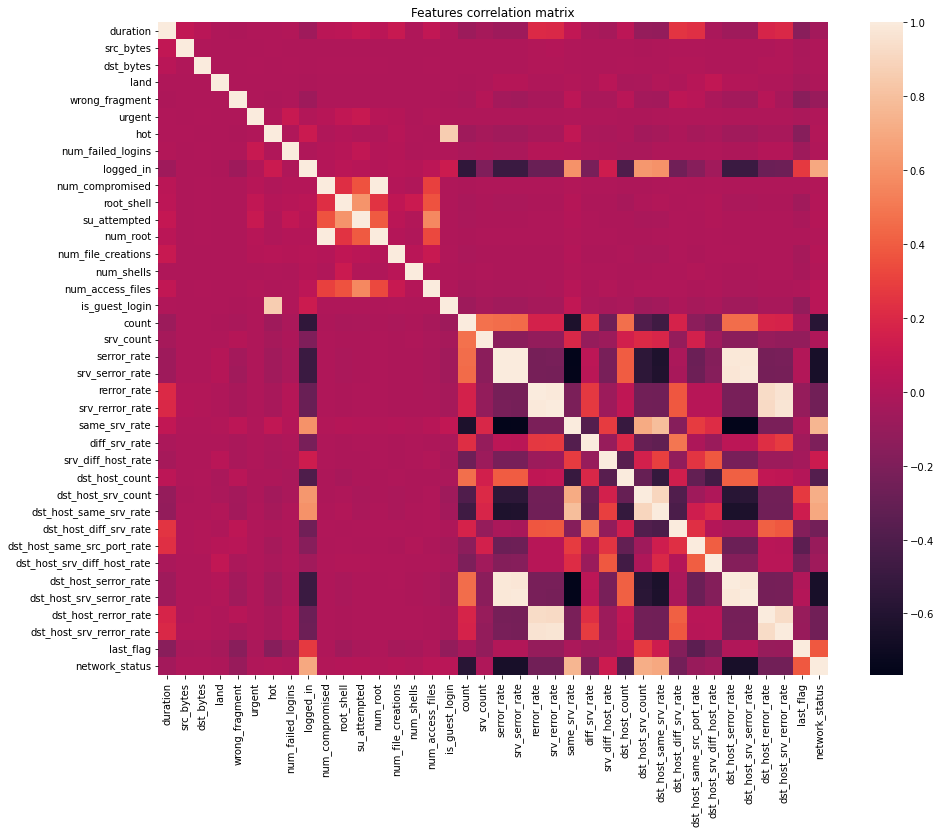

In [166]:
df = train_data[[col for col in train_data if train_data[col].nunique() > 1]]# keep columns where there are more than 1 unique values
  
corr = df.corr()
  
plt.figure(figsize =(15, 12))
  
sns.heatmap(corr)
plt.title('Features correlation matrix')
  
plt.show()

We clearly see that 5 features outstand the group concerning the relations with the ***network_status*** feature:

*   ***logged_in***: 1 if the connection successfully logged in; 0 otherwise
*   ***same_srv_rate***: The percentage of connections that were to the same service, among the
connections
*   ***dst_host_srv_count***:  Number of connections having the same port number
*   ***dst_host_same_srv_rate*** (which depends on the dst_host_srv_count so it is logic): The percentage of connections that were to the same service
*   and obviously ***network_status*** itself


We can notice that some features are strongly linked between each others. Indeed their coefficients is nearly around 1, meaning that they are strongly dependant: 

*   ***num_compromised*** and ***num_root*** have a correlation of 1
*   ***serror_rate***, ***srv_serror_rate***, ***dst_host_serror_rate*** and ***dst_host_srv_serror_rate*** all have a correlation of 1 between each other
*   ***rerror_rate***, ***srv_rerror_rate***, ***dst_host_rerror_rate*** and ***dst_host_srv_rerror_rate*** all have a correlation of 1 between each other

We will delete the redondances later.


Since our classifiers can't work on categorical features, we must find them and transform them into binary features. All the categorical features are described in the project's PDF as ***nominal features*** but we can find them with some simple instructions. If this work properly, we should find the nominal features: 

*   protocol_type
*   service
*   flag


In [167]:
# Finding categorical features
num_cols = train_data._get_numeric_data().columns
  
cate_cols = list(set(train_data.columns)-set(num_cols))
  
print(cate_cols)

['service', 'protocol_type', 'flag']


Once we identified those categorical features, we have to convert them into binary ones using the Dummy Coding. In Dummy Coding, each possible value of the feature corresponds to a vector. One is the zeros vector (0,0,0,...,0) and all the others are one-hot encoded vectors. Those vectors are zeros vectors with only one value equal to 1. This value equal to 1 designs the current category of the feature. To do so, we can use the function get_dummies from pandas which converts all string columns into binary.

In [168]:
nominal = ['protocol_type', 'service', 'flag']

# cast to string
for col in nominal:
    train_data[col] = train_data[col].apply(str)
    test_data[col] = test_data[col].apply(str)

# convert to binary features
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

In [169]:
columns = np.intersect1d(train_data.columns, test_data.columns).tolist()
train_columns = np.copy(columns).tolist()
train_columns.append('network_status')
train_data = train_data[[col for col in train_columns]]
test_data = test_data[[col for col in columns]]
print(train_data.shape)
print(test_data.shape)

(125973, 68)
(100, 67)


Now, if we look to the training dataset, it will have a lot more features than before since all the categorical features are now hot-encoded vectors. It means that each possible value for each categorical feature became a binary feature itself and only one of those features can be considered equal to 1 at the same time.

### 2.5 Graphic representations of the problem

First, we can display the amount of elements of the two classes to see if there is a majority of connection type. Indeed, it would affect our classification if there are a lot more normal connections than malicious and vice-versa.

0
1


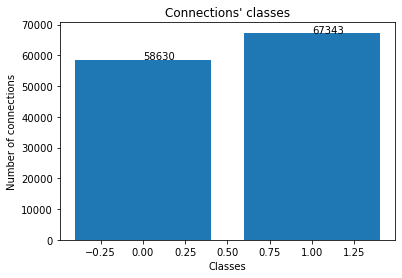

In [170]:
x = train_data['network_status'].unique()
y = train_data.groupby('network_status')['network_status'].count()
plt.bar((x+1)%2, y)
for index,data in enumerate(y):
    plt.text(x=index , y =data , s=f"{data}" , fontdict=dict(fontsize=10))
    print(index)
plt.title('Connections\' classes')
plt.xlabel('Classes')
plt.ylabel('Number of connections')
plt.show()

We observe that the dataset is well balanced since there are 58630 malicious connections against 67343 normal connections. 

To have a good understanding of the features, we can display the correlation matrix of the whole feature list and watch on which ones the ***network_status*** depends the most. 

In [171]:
train_data.drop('num_root', axis=1, inplace=True) 
train_data.drop('srv_serror_rate', axis=1, inplace=True) 
train_data.drop('dst_host_serror_rate', axis=1, inplace=True)
train_data.drop('dst_host_srv_serror_rate', axis=1, inplace=True)
train_data.drop('srv_rerror_rate', axis=1, inplace=True) 
train_data.drop('dst_host_rerror_rate', axis=1, inplace=True)
train_data.drop('dst_host_srv_rerror_rate', axis=1, inplace=True)

Then, we can pair-plot all those features together to have some assumptions on the type of model that we will use to classify our data. Since we want to make a binomial classification, we can head toward models like logistic regression or decision trees. Let's look into this with more details.

In [172]:
sns.set()
cols = ['network_status', 'logged_in', 'same_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'last_flag']
sns.pairplot(train_data[cols], height = 2.0)
plt.show()

KeyboardInterrupt: 

When we plot the ***network_status*** in function of the others features, we can clearly distinguish the two clusters of points corresponding to the two classes. It represents pretty well the theory of the logistic regression classifier. However we still need to plot the data into two different axes, ***dst_host_same_srv_rate*** and ***same_srv_rate*** for example, to visualize their effect on the clusters. 

In [ ]:
x1 = train_data['dst_host_same_srv_rate']
x2 = train_data['same_srv_rate']
y = train_data['network_status']

plt.figure(figsize=(6,5))
plt.scatter(x1, x2, c=y, cmap='coolwarm', label='test')
plt.title('Network connections training data representation')
plt.xlabel('dst_host_same_srv_rate')
plt.ylabel('same_srv_rate')
plt.legend(*scatter.legend_elements(num=1))
plt.show()

By looking into this representation, we can guess that a linear model won't classify the data correctly and that there will be a lot of errors on the predictions. We will still implement the logistic regression to have an idea of its accuracy and see how we can improve the prediction.

## 3. Choice of classifier

Before going further, we must differentiate few things: 

*   Features from labels
*   Train set from test set (issued from the Train.csv since we need the labels to compute the classifier's score)

Here, we only have one label: ***network_status***. All the other columns are the training features.



In [ ]:
# Target variable and train set
labels = train_data[['network_status']]
features = train_data.drop(['network_status', ], axis = 1)

sc = MinMaxScaler()        #score 0.98 with normalisation 
features = sc.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)


### 3.1 Linear model : Logistic regression

The logistic model that we will use here is the one from the scikit-learn library. We increased the max_iter to 1e6 since we have a lot of data. There are only few steps to configure it:

*   Creating the model with the hyper-parameter max_iter
*   Fitting the train data on the model 
*   Computing the scores to ensure that there is no overfitting


In [ ]:
def evaluate(model, cv, X, y):
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  return np.mean(scores)

In [91]:
model = LogisticRegression(max_iter = 1e6)
model.fit(X_train, y_train)
trains = list()
scores = list()
for k in range(2,10):  
  cv = KFold(n_splits=k)
  trains.append(evaluate(model,cv, X_train, y_train))
  scores.append(evaluate(model, cv, X_test, y_test))

C:\Users\Seb\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


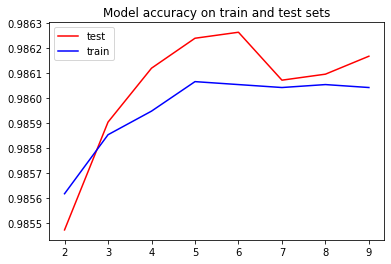

Best performances = 2.952309595449787e-05 for k = 7


In [93]:
plt.figure()
plt.title('Model accuracy on train and test sets')
plt.plot(range(2, 10), scores, c='r', label='test')
plt.plot(range(2,10), trains, c='b', label='train')
plt.legend()
plt.show()
print('Best performances = {} for k = {}'.format(np.min(np.abs(np.array(trains)-np.array(scores))), 2 + np.argmin(np.abs(np.array(trains)-np.array(scores)))))

When we compute both training and testing scores we notice that they are nearly the same. We can conclude that the training is effective and that there is no overfitting. In fact, when looking at the train and test curves, we see that we have a gap of 0.3% between each score. We have a test score of 97% with the normalization whereas we have a test score of 87% without it. The normalization reduces the gap that can exist between each feature of the model and make them all as important than the others. It helps to increase the accuracy. 

### 3.2 Non-linear models: Decision trees

As we seen above, a non linear model would suit better to our datasets. We will try different models and pick the fatest and best one. 

### 3.2.1 Decision tree classifier

Decision trees are used for classification. We must define a max_depth to prevent overfitting. Here we chose to have small trees to be sure we won't overfit our data. 

In [94]:
# Decision Tree 
clfd = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
clfd.fit(X_train, y_train.values.ravel())
trains = list()
scores = list()
for k in range(2, 20):  
  cv = KFold(n_splits=k)
  trains.append(evaluate(clfd,cv, X_train, y_train))
  scores.append(evaluate(clfd, cv, X_test, y_test))

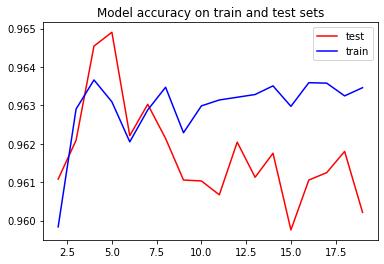

Best performances = 0.00014831547123173028 for k = 7
Train accuracy =  0.9628795688550376
Test accuracy =  0.9630278843262693


In [96]:
plt.figure()
plt.title('Model accuracy on train and test sets')
plt.plot(range(2, 20), scores, c='r', label='test')
plt.plot(range(2,20), trains, c='b', label='train')
plt.legend()
plt.show()
k = np.argmin(np.abs(np.array(trains)-np.array(scores)))
print('Best performances = {} for k = {}'.format(np.min(np.abs(np.array(trains)-np.array(scores))), 2 + k))
print('Train accuracy = ', trains[k])
print('Test accuracy = ', scores[k])

For k = 7 as K-fold hyperparameter, we have the best performance without having any kind overfitting or underfitting. Indeed, there is a gap of 0.01% between each set's accuracy and we have a score of 96%. However, it is still less than the logistic regression. We can try to find a better model.

### 3.2.2 Random forest

In [105]:
params_grid = { 
    "n_estimators": [60,70,80,90,100], 
    "max_features": [0.2,0.4,0.6,0.8,1],
    "max_depth": [None],
    "min_samples_leaf": [1]
}

# random forest
cv = KFold(n_splits=5)
forest = RandomForestClassifier(random_state=42)

# hyper-parameter search
forest_cv = GridSearchCV(forest, params_grid, cv=cv, n_jobs=4)
forest_cv.fit(X_train, y_train)

# best score
forest_score = forest_cv.score(X_test, y_test)

# recap
print('Training score: {:.4f}'.format(forest_cv.score(X_train, y_train)))
print('Random forest: {:.4f}'.format(forest_score))

C:\Users\Seb\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Training score: 1.0000
Random forest: 0.9994


With the best hyper-parameters, we have a test accuracy of 99,7% which is really huge. Since the gap between the train and test accuracy is only 0.14%, we can conclude that there is no overfitting. Because it is the best model among all those that we tested before, we will retain it to predict the ***network_status*** on the Test.csv dataset.

Here we can get the retained hyper-parameters to compute the best score. We will use this to create the model that we retain.

In [106]:
print(forest_cv.best_params_)

{'max_depth': None, 'max_features': 0.2, 'min_samples_leaf': 1, 'n_estimators': 90}


## 4. Prediction for the Test.csv dataset

### 4.1 Data preprocessing
We must apply all the normalizing process that we have already done before on the training dataset.

In [130]:
# Drop unnecessary features
test_data.drop('num_root', axis=1, inplace=True) 
test_data.drop('srv_serror_rate', axis=1, inplace=True) 
test_data.drop('dst_host_serror_rate', axis=1, inplace=True)
test_data.drop('dst_host_srv_serror_rate', axis=1, inplace=True)
test_data.drop('srv_rerror_rate', axis=1, inplace=True) 
test_data.drop('dst_host_rerror_rate', axis=1, inplace=True)
test_data.drop('dst_host_srv_rerror_rate', axis=1, inplace=True)
sc = MinMaxScaler() 
features = sc.fit_transform(features)

### 4.2 Train the chosen model
Now we can train a random forest model with the optimal parameters found above with the GridSearch. We fit all the train data in the model and predict the type of connection of the Test.csv dataset from its features. 

In [131]:
forest = RandomForestClassifier(random_state=42, n_estimators=90, max_features=0.2, min_samples_leaf=1,max_depth=None)
forest.fit(X_train, y_train)
ypred = forest.predict(test_data)

C:\Users\Seb\AppData\Local\Temp/ipykernel_19444/2477077324.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


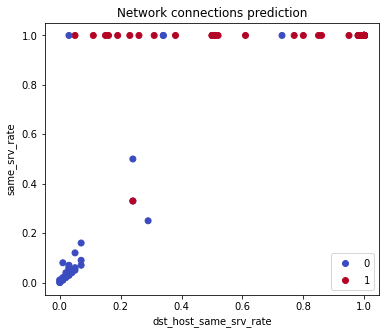

In [154]:
x1 = test_data['dst_host_same_srv_rate']
x2 = test_data['same_srv_rate']

plt.figure(figsize=(6,5))
scatter = plt.scatter(x1, x2, c=ypred, cmap='coolwarm')
plt.title('Network connections prediction')
plt.xlabel('dst_host_same_srv_rate')
plt.ylabel('same_srv_rate')
plt.legend(*scatter.legend_elements(num=1))
plt.show()

In [174]:
test_data['prediction'] = ypred
test_data.head()

,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_count,...,service_uucp,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,su_attempted,urgent,wrong_fragment,prediction
0,229,0.06,0,255,0.06,1.00,0.00,0.04,0.0,10,...,0,0,10,0.00,1.0,0.00,0,0,0,0
1,136,0.06,0,255,0.06,1.00,0.00,0.00,0.0,1,...,0,0,1,0.00,1.0,0.00,0,0,0,0
2,1,0.00,0,134,0.04,0.00,0.61,0.61,0.0,86,...,0,12983,1,0.00,0.0,0.00,0,0,0,1
3,1,0.00,0,3,0.00,0.00,1.00,1.00,0.0,57,...,0,20,65,1.00,0.0,0.00,0,0,0,0
4,1,0.00,15,29,0.17,0.83,0.03,0.31,0.0,86,...,0,0,8,0.75,0.5,0.12,0,0,0,1


In [175]:
test_data.to_csv('results.csv')

When we represent all the predictions we clearly see something similair to the first point representation and can deduce that the predictions nicely fit to our model. However, we still can't know about the rightness of our results, only you have the true values :)

This conclude our project. We normalized all our data to make it easier to fit to machine learning models. From the graphical representations, we were able to make assumptions about the kind of model to use. We tested different kind to test our assumptions and proved that non-linear models fitted more accuratly to our datasets. Lastly, we trained the model which had the best results and were able to predict data. 